## 데이터 불러오기

In [1]:
### 와인 데이터 사용
import pandas as pd

wine = pd.read_csv('./data/08_wine.csv')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [2]:
wine.info()
# alchol 알콜도수 sugar 당도 pH 농도 class 와인종류
### 범주 : 와인종류(0=레드와인 1=화이트와인)
# - 범주가 2개인 이진분류
# - 범주의 값이 1인 화이트와인 찾는게 목적

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [3]:
wine.corr()

,alcohol,sugar,pH,class
alcohol,1.000000,-0.359415,0.121248,0.032970
sugar,-0.359415,1.000000,-0.267320,0.348821
pH,0.121248,-0.267320,1.000000,-0.329129
class,0.032970,0.348821,-0.329129,1.000000


In [4]:
wine_input = wine[['alcohol','sugar','pH']].to_numpy()
wine_target = wine['class'].to_numpy()

In [5]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(wine_input, wine_target, random_state=42)

In [6]:
### 정규화(표준화) -> 독립변수 표준점수로 동일하게 표준화(스케일)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

print(ss.mean_, ss.scale_)
print("-----------------------")
print(train_scaled[ :5])
print("-----------------------")
print(test_scaled[ :5])

[10.49046798  5.45803571  3.21665846] [1.19475276 4.78329406 0.15985536]
-----------------------
[[-0.49421772 -0.76475242  1.52226079]
 [ 0.25907621 -0.70203414 -0.29187922]
 [-0.24311974 -0.70203414  1.14692148]
 [-0.91271434  0.99135956 -0.22932266]
 [ 0.59387351 -0.36753662 -0.10420956]]
-----------------------
[[ 1.43086676  1.53491803  0.27112975]
 [-0.49421772 -0.68112804  0.3336863 ]
 [ 1.26346811  0.4059889  -0.22932266]
 [-0.82901502  1.20042051 -0.60466197]
 [-1.33121097  1.76488507 -0.66721853]]


## 먼저, 로지스틱 회귀분류

In [7]:
# 계수 및 y절편 출력
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled, train_target)

##3 훈련모델 분류 정확도 확인하기
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

### 계수, y절편
print(lr.coef_, lr.intercept_)

###(해석)
# - 훈련 및 테스트 모두 매우 낮은 정확도 보임
# - 과소적합 보임

0.7859195402298851
0.7655384615384615
[[ 0.53273869  1.67940585 -0.7090217 ]] [1.84713933]


- 문제

In [8]:
pre_data = wine[['alcohol','sugar','pH']].to_numpy()
class_pred = ss.transform(pre_data)

In [9]:
result_predict = lr.predict(class_pred)

wine_pred = wine[['alcohol','sugar','pH']]
wine_pred['class'] = wine['class']
wine_pred['class_pred'] = result_predict
wine_pred.head(10)

,alcohol,sugar,pH,class,class_pred
0,9.4,1.9,3.51,0.0,0.0
1,9.8,2.6,3.20,0.0,1.0
2,9.8,2.3,3.26,0.0,1.0
3,9.8,1.9,3.16,0.0,1.0
4,9.4,1.9,3.51,0.0,0.0
5,9.4,1.8,3.51,0.0,0.0
6,9.4,1.6,3.30,0.0,0.0
7,10.0,1.2,3.39,0.0,0.0
8,9.5,2.0,3.36,0.0,0.0
9,10.5,6.1,3.35,0.0,1.0


In [10]:
o = len(wine_pred[(wine_pred['class'] == wine_pred['class_pred'])])
x = len(wine_pred[(wine_pred['class'] != wine_pred['class_pred'])])

sum = len(wine_pred)

# 정답/오답률
import numpy as np

o_p = np.round(o / sum * 100, 2)
x_p = np.round(x / sum * 100, 2)

print(f'총 갯수 [{sum}] 중 정답 개수[{o}], 오답 개수[{x}]')
print('정답률 =', o_p,'%, 오답률 = ',x_p,'%')

총 갯수 [6497] 중 정답 개수[5073], 오답 개수[1424]
정답률 = 78.08 %, 오답률 =  21.92 %


## 결정트리(Decision Tree)
##### - 질문(조건)을 통해 트리(True와 Flase) 2개씩 가지를 치면서 분류
##### - 질문을 스스로 찾아서, 계속해서 질문(조건)을 만들어 나가면서 분류(트리)함
##### - 더 이상 질문이 없으면 결정(Decision)하게 됨
##### - 분류 정확도 높다
##### - 질문(조건)을 통해 분류해 나가는 절차를 시각화 가능(장점)
##### - 시각화 함수 : 사이키런 패키지의 plot_tree(모델변수)

In [11]:
### 사용하는 클래스 : DecisionTreeClassifier
### 사용하는 패키지 : sklearn.tree

from sklearn.tree import DecisionTreeClassifier

### 클래스 생성
# - 실제 사용시에는 random_state은 사용하지 않는 것이 좋음
# - random_state의 값이 변경되면 정확도 점수 변경
# - 보통 random_state은 실전에서는 사용하지 않는 편
dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(train_scaled, train_target)

print(dtc.score(train_scaled, train_target))
print(dtc.score(test_scaled, test_target))

### (해석)
# - 훈련결과는 아주 우수하나 테스트 결과가 상대적으로 낮게 나옴
# - 과대적합 발생

0.9973316912972086
0.8516923076923076


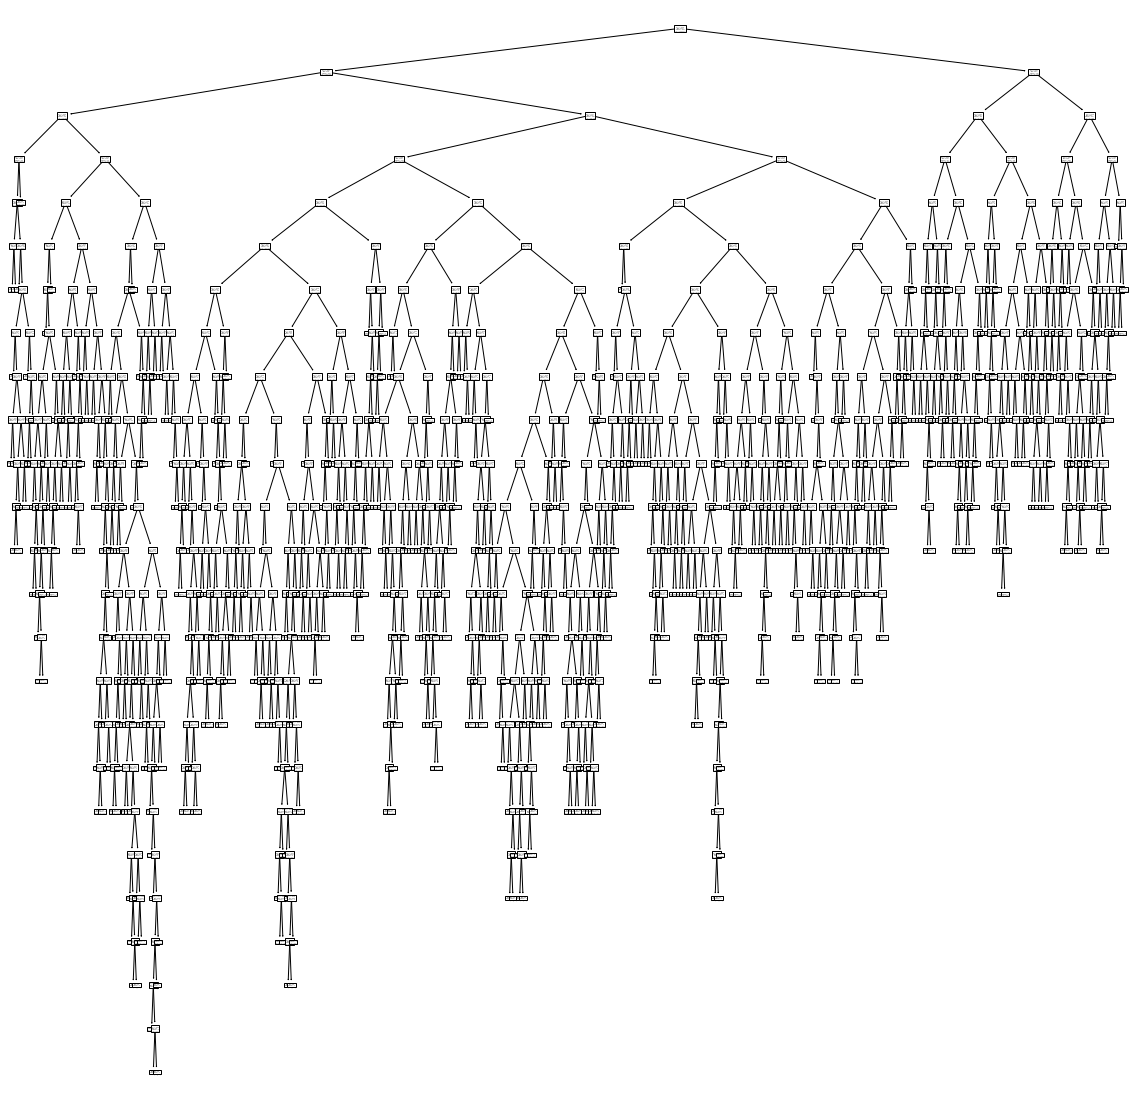

In [12]:
### 트리 시각화
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(dtc)
plt.show()

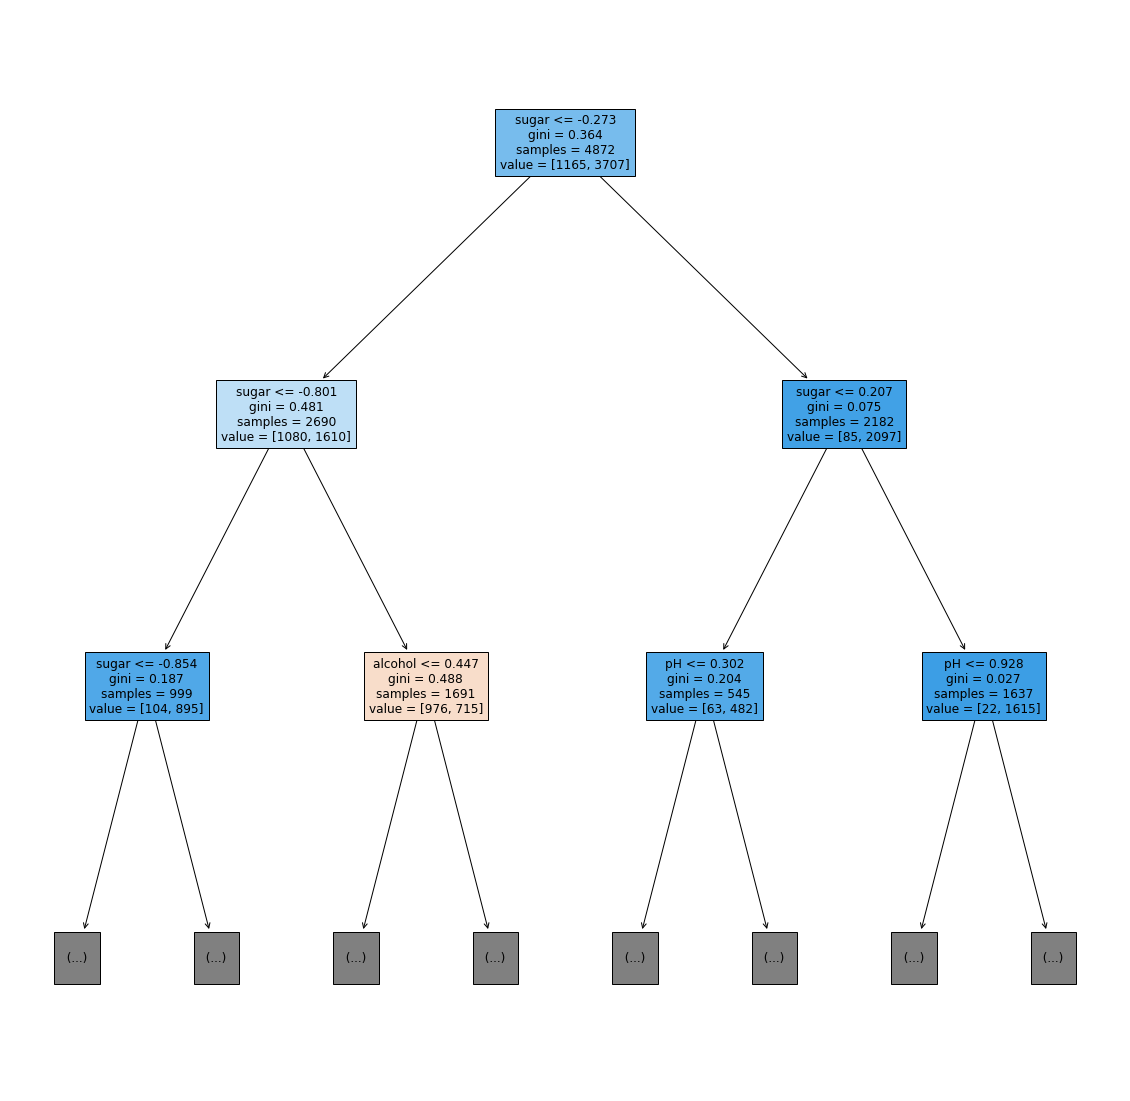

In [13]:
### 트리 시각화
# - 일부만 확인
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# max_depth : 트리의 깊이(첫번째를 제외하고 2개까지 만들기)
# filled : 색으로 독립변수별 구분
# feature_names : 사용된 독립변수 이름
plt.figure(figsize=(20,20))
plot_tree(dtc, max_depth=2, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

# - gini : 불순도
# - samples : 훈련에 사용된 데이터 수
# - value : 범주별로 사용된 데이터 수

# - 가장 첫번째 트리 : 루트노드(root node)
# - 가장 아래 트리 :리프토드(leaf node)

## 가지치기
##### - max_depth : 트리의 갯수로 제한
##### - 트리가 너무 뻗어 나가도 정확도가 떨어집니다
##### - 제한 없이 뻗어 나가는 것을 max_depth로 제어

In [14]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=3)

dtc.fit(train_scaled, train_target)

print(dtc.score(train_scaled, train_target))
print(dtc.score(test_scaled, test_target))

0.8499589490968801
0.8363076923076923


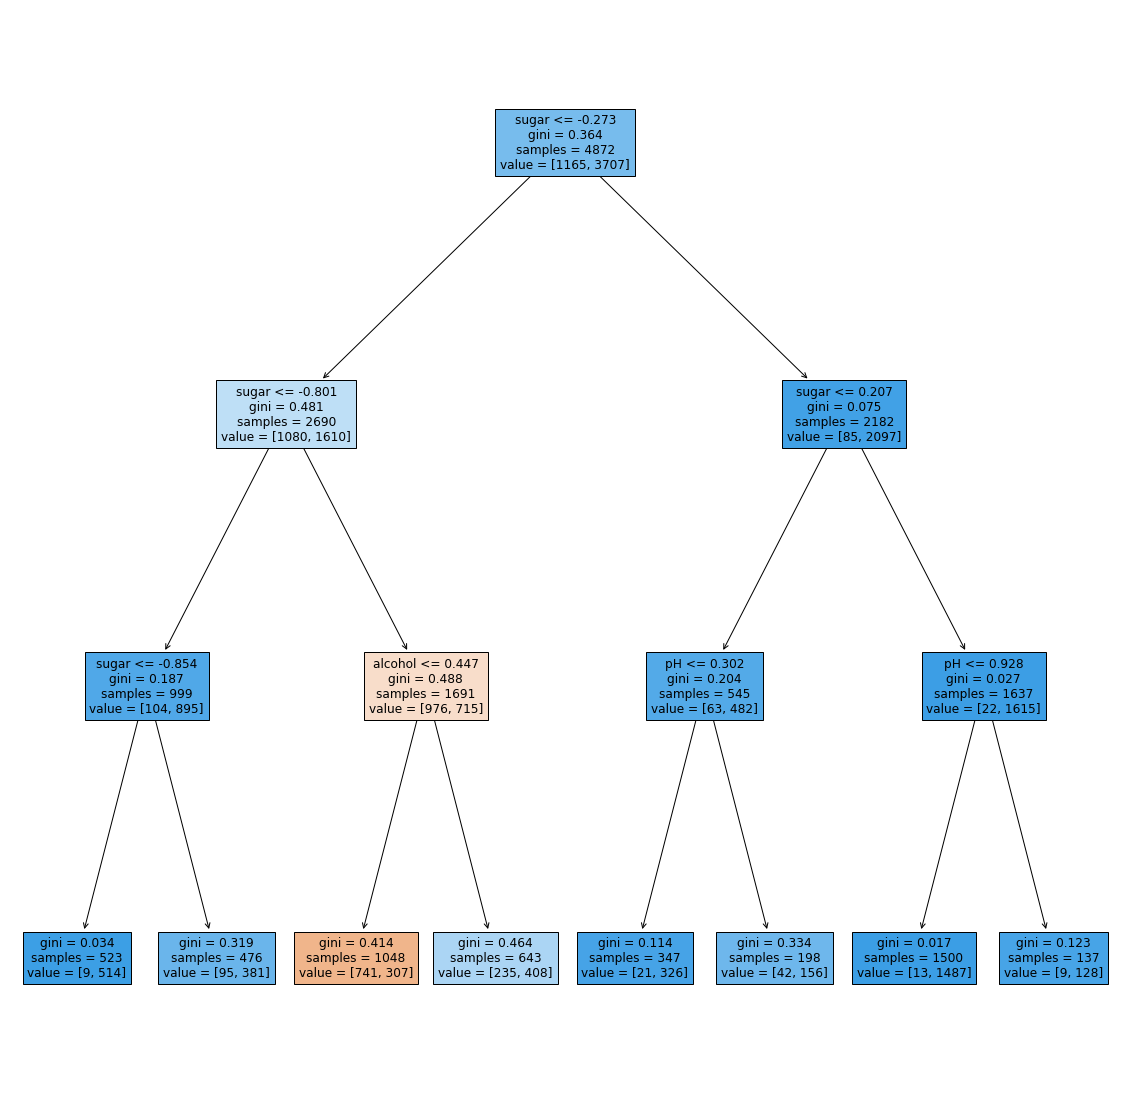

In [15]:
plt.figure(figsize=(20,20))
plot_tree(dtc,filled=True,feature_names=['alcohol','sugar','pH'])
plt.show()

## 특성중요도

In [16]:
### 트리 훈련에 사용된 독립변수(특성=퓨처)들의 정확도 확인
# - 정확도가 가장 높은 독립변수가 훈련에 영향을 가장 많이 미쳤다고 판단

In [17]:
print(dtc.feature_importances_)

[0.12871631 0.86213285 0.00915084]


In [31]:
## 알콜+슈가 -> 최적

w = wine[['alcohol','sugar']].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(w, wine_target, random_state=42)

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

dtc = DecisionTreeClassifier(random_state=42, max_depth=2)
dtc.fit(train_scaled, train_target)
print(dtc.score(train_scaled, train_target))
print(dtc.score(test_scaled, test_target))

# plt.figure(figsize=(20,20))
# plot_tree(dtc, filled=True, feature_names=['alcohol','sugar','pH'])
# plt.show()

0.8144499178981938
0.8086153846153846


In [19]:
## suger+ph

w = wine[['pH','sugar']].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(w, wine_target, random_state=42)

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

dtc = DecisionTreeClassifier(random_state=42, max_depth=3)
dtc.fit(train_scaled, train_target)
print(dtc.score(train_scaled, train_target))
print(dtc.score(test_scaled, test_target))

0.8386699507389163
0.8055384615384615


In [20]:
## pH+alcohol
w = wine[['pH','alcohol']].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(w, wine_target, random_state=42)

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

dtc = DecisionTreeClassifier(random_state=42, max_depth=3)
dtc.fit(train_scaled, train_target)
print(dtc.score(train_scaled, train_target))
print(dtc.score(test_scaled, test_target))

0.7608784893267652
0.7329230769230769


In [21]:
## pH+alcohol
w = wine[['sugar']].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(w, wine_target, random_state=42)

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

dtc = DecisionTreeClassifier(random_state=42, max_depth=3)
dtc.fit(train_scaled, train_target)
print(dtc.score(train_scaled, train_target))
print(dtc.score(test_scaled, test_target))

0.8366174055829229
0.824


In [33]:
predict_data = wine[['alcohol','sugar']].to_numpy()
ss.fit(predict_data)
class_pred = ss.transform(predict_data)
result_predict = dtc.predict(predict_data)

wine_pred = wine[['alcohol','sugar']]
wine_pred['class'] = wine['class']
wine_pred['class_pred'] = result_predict
wine_pred.head(10)

C:\Users\admin\AppData\Local\Temp\ipykernel_7900\3380569645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_pred['class'] = wine['class']


,alcohol,sugar,class,class_pred
0,9.4,1.9,0.0,1.0
1,9.8,2.6,0.0,1.0
2,9.8,2.3,0.0,1.0
3,9.8,1.9,0.0,1.0
4,9.4,1.9,0.0,1.0
5,9.4,1.8,0.0,1.0
6,9.4,1.6,0.0,1.0
7,10.0,1.2,0.0,1.0
8,9.5,2.0,0.0,1.0
9,10.5,6.1,0.0,1.0


In [34]:
o = len(wine_pred[(wine_pred['class'] == wine_pred['class_pred'])])
x = len(wine_pred[(wine_pred['class'] != wine_pred['class_pred'])])

sum = len(wine_pred)

# 정답/오답률
import numpy as np

o_p = np.round(o / sum * 100, 2)
x_p = np.round(x / sum * 100, 2)

print(f'총 갯수 [{sum}] 중 정답 개수[{o}], 오답 개수[{x}]')
print('정답률 =', o_p,'%, 오답률 = ',x_p,'%')

총 갯수 [6497] 중 정답 개수[4898], 오답 개수[1599]
정답률 = 75.39 %, 오답률 =  24.61 %
